# Image Segmentation 
### Author: Sanjay Jaras
### Bellevue University

## Import Libraries

In [1]:
#!pip install git+https://github.com/tensorflow/examples.git
import os
import tensorflow as tf 
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.layers.experimental import preprocessing 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import numpy as np
from tqdm import tqdm
import random

## Load image file paths

In [2]:
#voc_path = "../input/pascal-voc-2012/VOC2012/"
voc_path = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/"
train_text_file = os.path.join(voc_path, "ImageSets/Segmentation/train.txt")
val_text_file = os.path.join(voc_path, "ImageSets/Segmentation/val.txt")
image_folder = os.path.join(voc_path, "JPEGImages")
mask_folder = os.path.join(voc_path, "SegmentationClass")

In [3]:
def read_paths_img_masks(text_file_path, image_path, mask_path):
    paths = []
    with open(text_file_path, "r") as file:
        file_names = file.readlines()
    for file_name in tqdm(file_names):
        image = os.path.join(image_path, file_name.strip() + ".jpg")
        mask = os.path.join(mask_path, file_name.strip() + ".png")
        paths.append((image, mask))
    return paths


## Split files into Train, Test and Validation dataset

In [4]:

train_paths = read_paths_img_masks(train_text_file, image_folder, mask_folder)
val_paths = read_paths_img_masks(val_text_file, image_folder, mask_folder)

# Adding 1000 paths from validation dataset to training dataset increase training dataset size
train_paths.extend(val_paths[0:700])
test_paths = val_paths[700:1000]
val_paths = val_paths[1000:]

#train_paths = tf.data.Dataset.from_tensors(train_paths)
#val_paths = tf.data.Dataset.from_tensors(val_paths)


100%|██████████| 1449/1449 [00:00<00:00, 580583.35it/s]


## Functions
* **normalize**: Normalize the image data and replace white color to last class
* **load_image_to_array**: Load image into array and resize it to 256*256 pixels
* **load_image_and_mask**: Load original image and masks

In [5]:

dim = 224
img_size = (dim, dim)
input_shape = [dim, dim, 3]

def normalize(input_image, input_mask1):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = input_mask1.copy()
    input_mask[input_mask == 255] = 21
    return input_image, input_mask


def load_image_to_array(file_path):
    with open(file_path, "rb") as f:
        img = PIL.Image.open(f) 
        img = img.resize(img_size)
        nparr = np.asarray(img)
        #print("nparr:", nparr.shape)
        return nparr

def load_image_and_mask(paths_tuple):
    input_image = load_image_to_array(paths_tuple[0])
    input_mask = load_image_to_array(paths_tuple[1])
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask


## Functions
* **augmentImage**: Augment original Image by flipping horizontally or vertically
* **augmentMask**: Augment original Mask by flipping horizontally or vertically
* **load_dataset**: Load all datasets

In [6]:
def augmentImage(img, left_right=True):
    aug_img = tf.image.flip_left_right(img)
    if left_right is True:
        aug_img = tf.image.flip_left_right(img)
    else:
        aug_img = tf.image.flip_up_down(img)
    return aug_img

def augmentMask(mask, left_right=True):
    mask = mask[..., np.newaxis]
    if left_right is True:
        aug_mask = tf.image.flip_left_right(mask)
    else:
        aug_mask = tf.image.flip_up_down(mask)
    aug_mask = aug_mask[:, :, 0]
    mask = mask[:, :, 0]
    return aug_mask


def load_dataset(paths, augment=False):
    imgs = []
    masks = []
    for path in tqdm(paths):
        #print("Processing: ", path)
        img, mask = load_image_and_mask(path)
        imgs.append(img)
        masks.append(mask)
        if augment is True:
            imgs.append(augmentImage(img))
            masks.append(augmentMask(mask))
            imgs.append(augmentImage(img, False))
            masks.append(augmentMask(mask, False))
            

        # break

    return np.array(imgs), np.array(masks)


## Load images into lists

In [7]:
print("Loading Training Dataset...")
train_images, train_masks = load_dataset(train_paths, True)
print("Loading Validation Dataset...")
val_images, val_masks = load_dataset(val_paths)
print("Loading Test Dataset...")
test_images, test_masks = load_dataset(test_paths)


TRAIN_LENGTH = len(train_images)
VAL_LENGTH = len(val_images)
print("Training dataset size:", len(train_images))
print("Test dataset size:", len(test_images))
print("Validation dataset size:", len(val_images))


Loading Training Dataset...


  0%|          | 0/2164 [00:00<?, ?it/s]2021-10-17 14:40:14.439463: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-17 14:40:14.439673: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-17 14:40:14.440665: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
100%|██████████| 2164/2164 [00:15<00:00, 142.20it/s]


Loading Validation Dataset...


100%|██████████| 449/449 [00:02<00:00, 174.67it/s]


Loading Test Dataset...


100%|██████████| 300/300 [00:01<00:00, 166.24it/s]


Training dataset size: 6492
Test dataset size: 300
Validation dataset size: 449


## Utility function to display Input image, mask and predicted mask side by side.

In [8]:
def display_images(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()


## Augmented images and masks

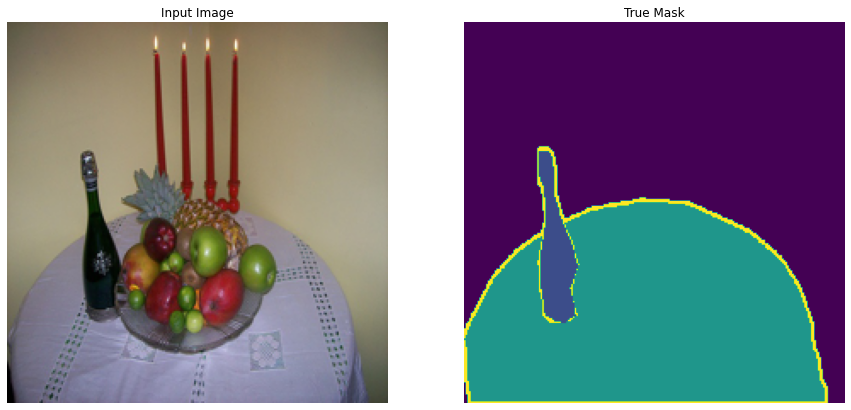

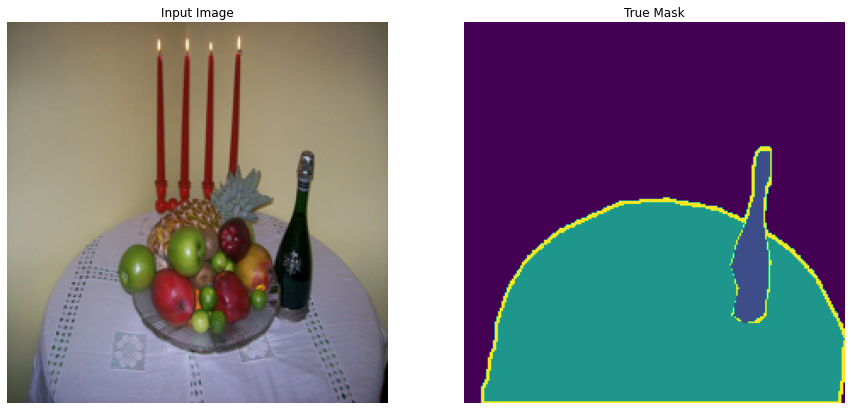

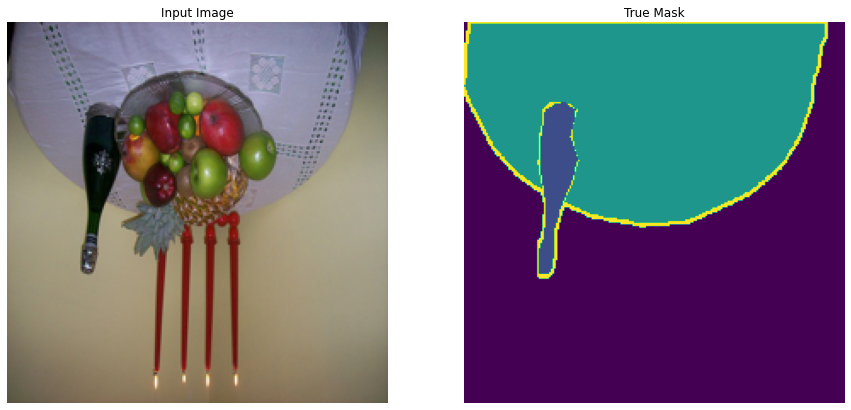

In [9]:
for i in range(24,27):
    display_images([train_images[i], train_masks[i]])

## Load datasets into TensorSliceDataset

In [10]:
train_images_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
del train_images, train_masks
test_images_ds = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
del test_images, test_masks
val_images_ds = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
del val_images, val_masks


## Define Batch size

In [11]:
BUFFER_SIZE = TRAIN_LENGTH
BATCH_SIZE = 32


## Create Batches for all 3 dataset

In [12]:
train_batches = (
    train_images_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    #.map(Augment())
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))
    #tf.data.AUTOTUNE

test_batches = test_images_ds.batch(BATCH_SIZE)
val_batches = val_images_ds.batch(BATCH_SIZE)

## Sample images and masks

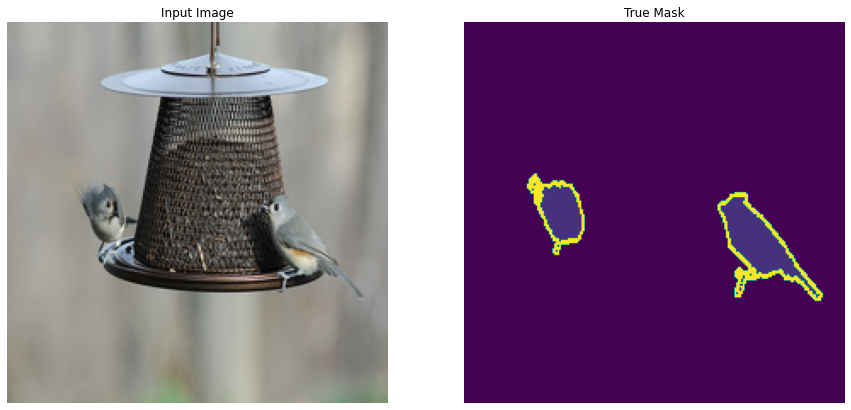

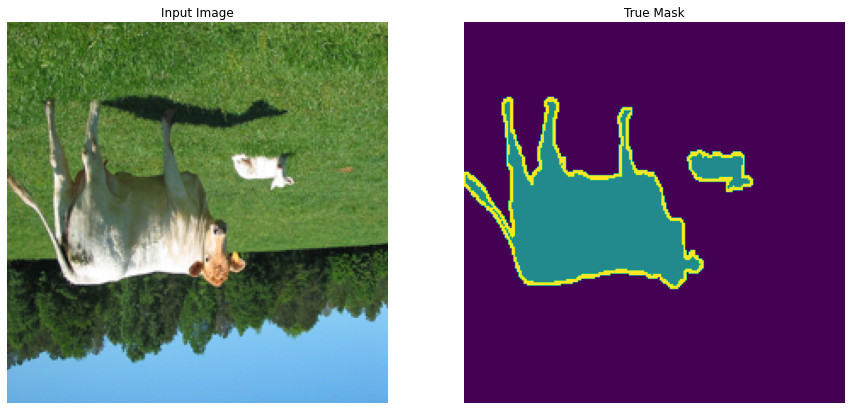

In [13]:
for images, masks in train_batches.take(2).cache():
    sample_image, sample_mask = images[0], masks[0]
    display_images([sample_image, sample_mask])

## Define Model using MobileNetV2
Use pretrained model MobileNetV2 and pick the layers for downsampling

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

## Pick the layers for upsampling

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

## Combine above steps to create UNET model

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=input_shape)

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=2, strides=2,
      #activation="sigmoid",
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Compile unet model

In [17]:
OUTPUT_CLASSES = 22

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

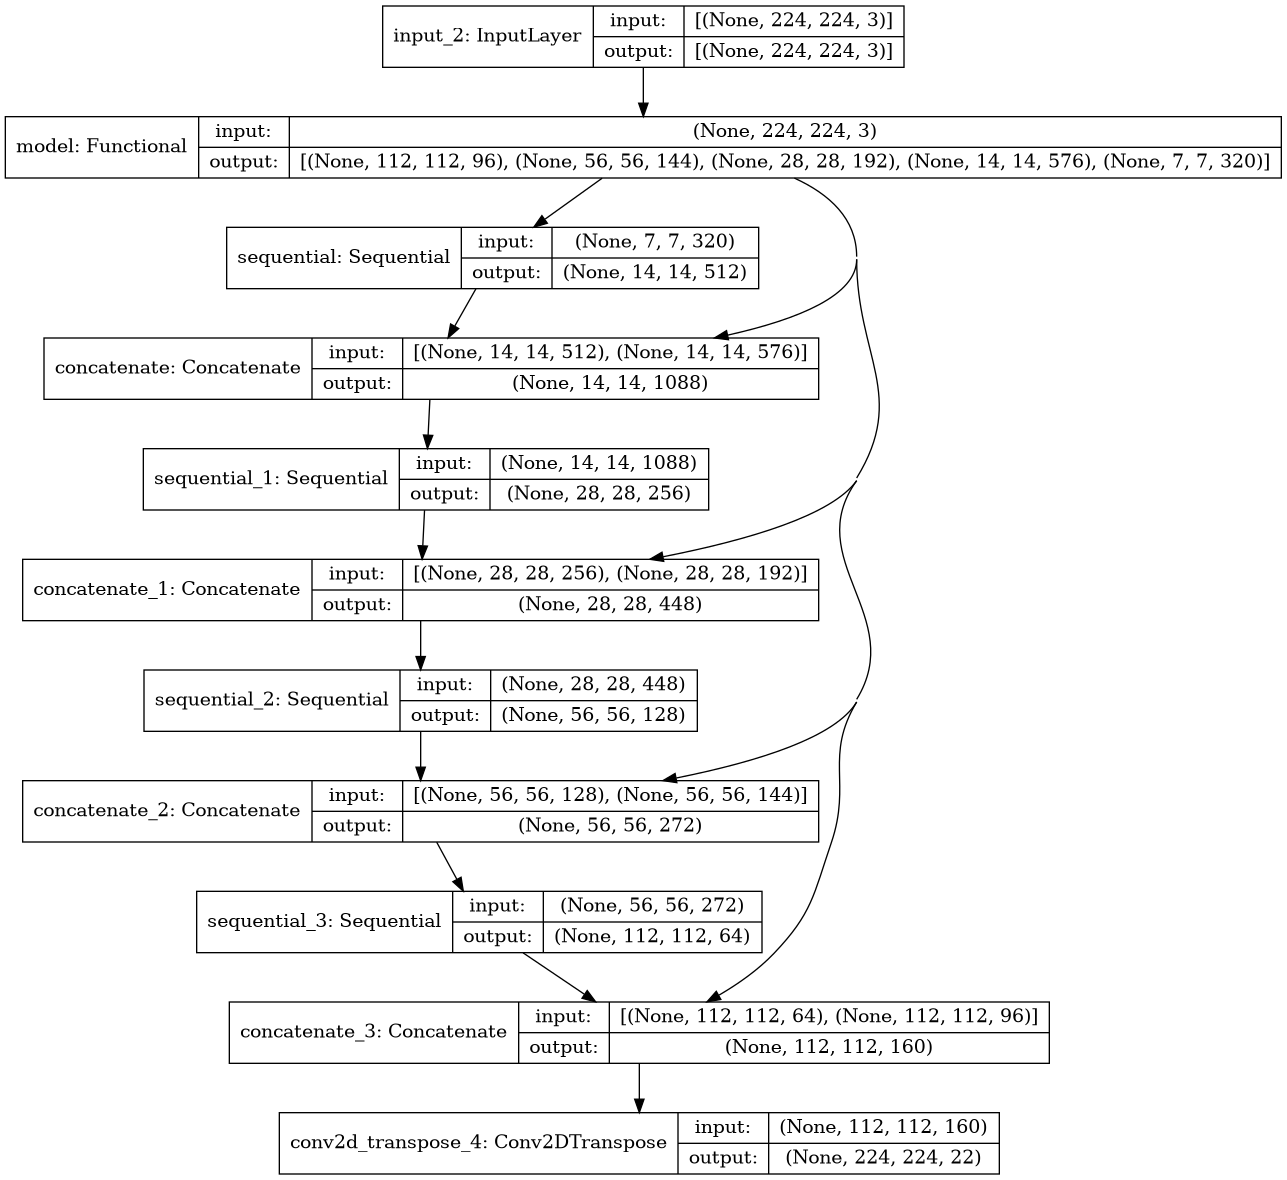

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Functions to create mask 

In [19]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

## Functions to show detected classes, predictions alongside true mask and image 

In [20]:
classes = {0:"background", 1:"aeroplane", 2:"bicycle", 3:"bird", 4:"boat", 5:"bottle", 6:"bus", 7:"car", 
           8:"cat", 9:"chair", 10:"cow", 11:"diningtable", 12:"dog", 13:"horse", 14:"motorbike", 15:"person", 
           16:"potted plant", 17:"sheep", 18:"sofa", 19:"train", 20:"tv/monitor",21:"Unknown"}

def print_classes(class_arr):
    print("\nClasses detected:")
    for clz in class_arr:
        print(clz, classes[clz])

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = create_mask(model.predict(image))
            print_classes(np.unique(pred_mask))
            display_images([image[0], mask[0], pred_mask])
    else:
        pred_mask = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        print_classes(np.unique(pred_mask))
        display_images([sample_image, sample_mask,pred_mask])
        

## Predictions before training the model

2021-10-17 14:40:41.038622: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-17 14:40:41.055915: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3601435000 Hz



Classes detected:
0 background
1 aeroplane
2 bicycle
3 bird
4 boat
5 bottle
6 bus
7 car
8 cat
9 chair
10 cow
11 diningtable
12 dog
13 horse
14 motorbike
16 potted plant
17 sheep
18 sofa
19 train
20 tv/monitor
21 Unknown


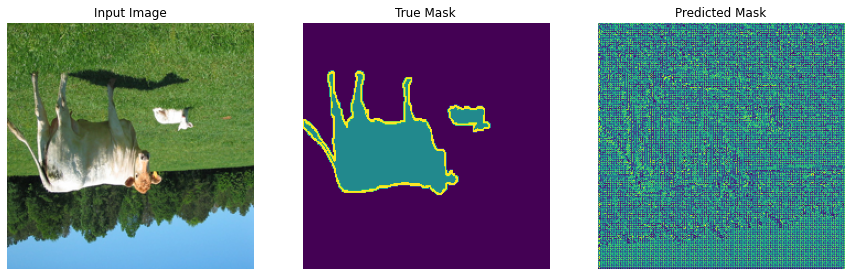

In [21]:
show_predictions()

## Callback functions for early stopping and Displaying information

In [22]:
earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.005, restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        #clear_output(wait=True)
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))
        show_predictions()
        #for key in logs.keys():
        #    print("epoch {}, the {} is {:7.2f}.".format(
        #     (epoch+1), key, logs[key]))
        #print(logs.keys())

## Train the model

Epoch 1/30
202/202 [==============================] - 543s 3s/step - loss: 1.5218 - accuracy: 0.6297 - val_loss: 1.0282 - val_accuracy: 0.7113

Sample Prediction after epoch 1


Classes detected:
0 background
1 aeroplane
3 bird
8 cat
10 cow
12 dog
13 horse
14 motorbike
17 sheep
21 Unknown


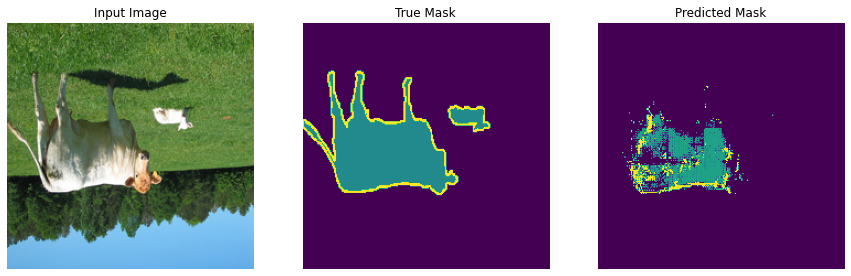

Epoch 2/30
202/202 [==============================] - 529s 3s/step - loss: 0.8427 - accuracy: 0.7600 - val_loss: 0.7738 - val_accuracy: 0.7516

Sample Prediction after epoch 2


Classes detected:
0 background
1 aeroplane
8 cat
10 cow
12 dog
13 horse
21 Unknown


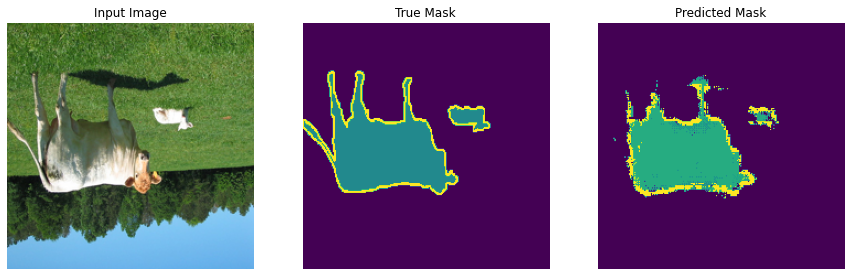

Epoch 3/30
202/202 [==============================] - 524s 3s/step - loss: 0.6837 - accuracy: 0.7953 - val_loss: 0.7434 - val_accuracy: 0.7809

Sample Prediction after epoch 3


Classes detected:
0 background
3 bird
10 cow
12 dog
13 horse
17 sheep
21 Unknown


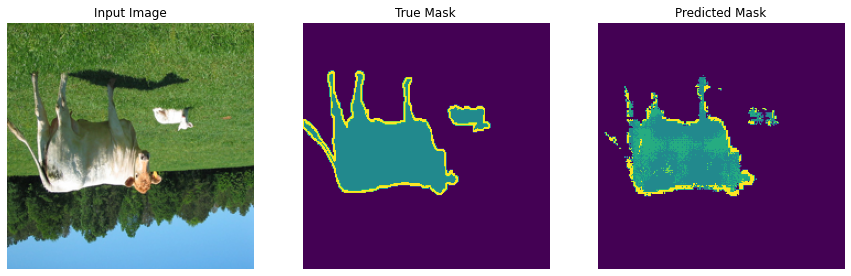

Epoch 4/30
202/202 [==============================] - 522s 3s/step - loss: 0.6355 - accuracy: 0.8073 - val_loss: 0.6696 - val_accuracy: 0.7951

Sample Prediction after epoch 4


Classes detected:
0 background
10 cow
13 horse
17 sheep
21 Unknown


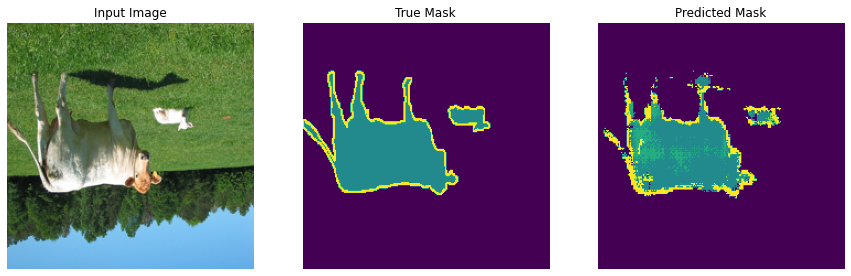

Epoch 5/30
202/202 [==============================] - 527s 3s/step - loss: 0.5672 - accuracy: 0.8259 - val_loss: 0.6601 - val_accuracy: 0.7981

Sample Prediction after epoch 5


Classes detected:
0 background
10 cow
13 horse
17 sheep
21 Unknown


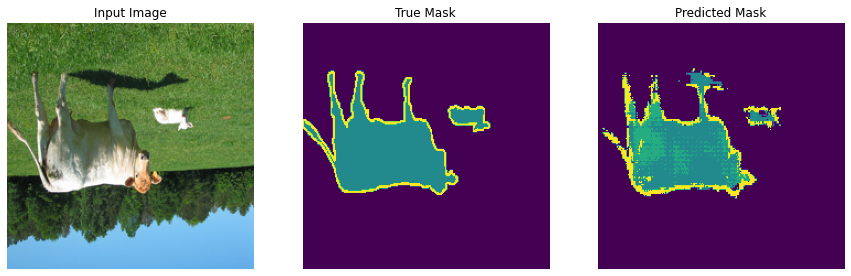

Epoch 6/30
202/202 [==============================] - 526s 3s/step - loss: 0.5450 - accuracy: 0.8315 - val_loss: 0.6641 - val_accuracy: 0.7938

Sample Prediction after epoch 6


Classes detected:
0 background
3 bird
10 cow
17 sheep
21 Unknown


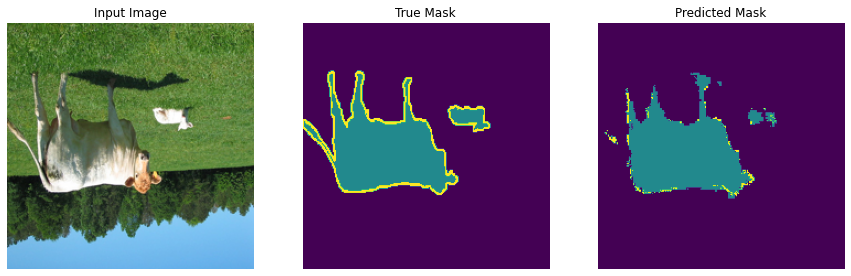

Epoch 7/30
202/202 [==============================] - 525s 3s/step - loss: 0.5268 - accuracy: 0.8349 - val_loss: 0.6487 - val_accuracy: 0.8053

Sample Prediction after epoch 7


Classes detected:
0 background
10 cow
13 horse
17 sheep
21 Unknown


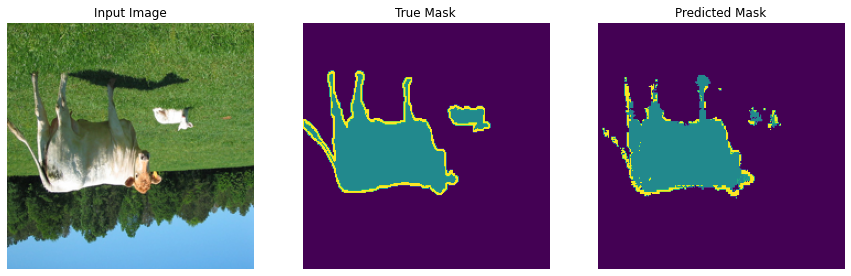

Epoch 8/30
202/202 [==============================] - 526s 3s/step - loss: 0.4875 - accuracy: 0.8469 - val_loss: 0.6432 - val_accuracy: 0.8014

Sample Prediction after epoch 8


Classes detected:
0 background
10 cow
13 horse
17 sheep
21 Unknown


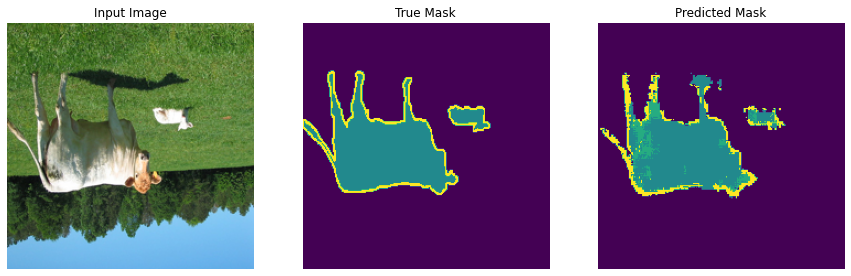

Epoch 9/30
202/202 [==============================] - 527s 3s/step - loss: 0.4845 - accuracy: 0.8460 - val_loss: 0.6948 - val_accuracy: 0.7930

Sample Prediction after epoch 9


Classes detected:
0 background
10 cow
13 horse
17 sheep
21 Unknown


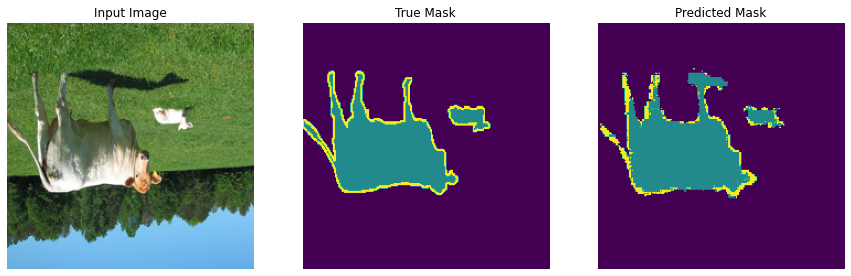

Epoch 10/30
202/202 [==============================] - 526s 3s/step - loss: 0.4576 - accuracy: 0.8538 - val_loss: 0.6520 - val_accuracy: 0.8028

Sample Prediction after epoch 10


Classes detected:
0 background
10 cow
13 horse
21 Unknown


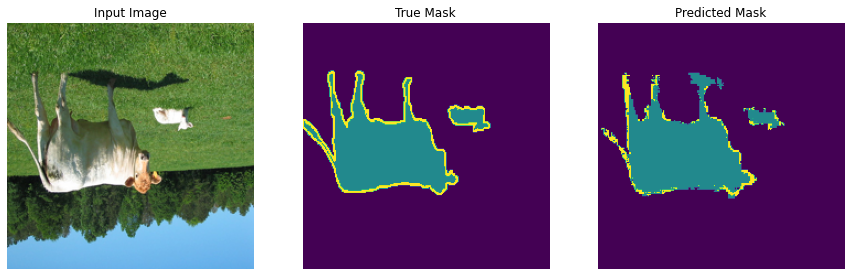

Epoch 11/30
202/202 [==============================] - 530s 3s/step - loss: 0.4346 - accuracy: 0.8596 - val_loss: 0.6413 - val_accuracy: 0.8068

Sample Prediction after epoch 11


Classes detected:
0 background
10 cow
13 horse
17 sheep
21 Unknown


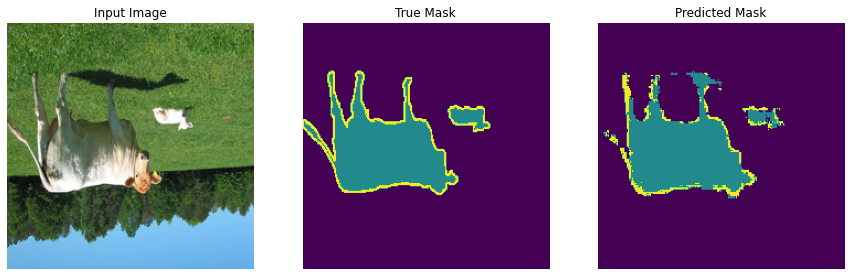

In [23]:
EPOCHS = 30
VAL_SUBSPLITS = 5
VALIDATION_STEPS = VAL_LENGTH//BATCH_SIZE//VAL_SUBSPLITS #10
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[DisplayCallback(), earlyStopCallback])

## Plot accuracy and loss for training and validations

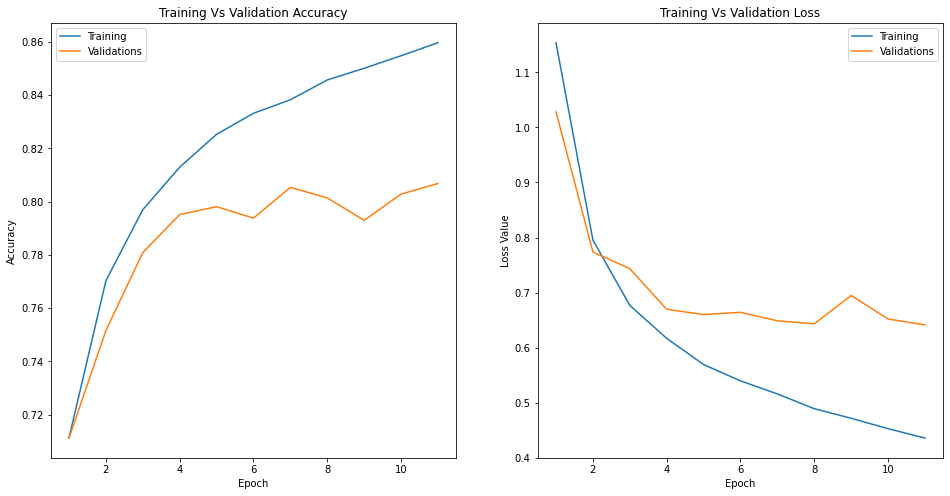

In [24]:
length = len(model_history.history["accuracy"])+1

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
titles = ['Training Vs Validation Accuracy', 'Training Vs Validation Loss']
ax[0].set_title(titles[0])
ax[0].plot(range(1, length), model_history.history["accuracy"])
ax[0].plot(range(1, length), model_history.history["val_accuracy"])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(["Training", "Validations"])


ax[1].set_title(titles[1])
ax[1].plot(range(1, length), model_history.history["loss"])
ax[1].plot(range(1, length), model_history.history["val_loss"])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss Value')
ax[1].legend(["Training", "Validations"])
plt.show()

## Evalute model against test dataset

In [25]:
model.evaluate(test_batches)

10/10 [==============================] - 6s 631ms/step - loss: 0.4815 - accuracy: 0.8518


[0.48146042227745056, 0.8518447875976562]

## Sample predictions from validation dataset


Classes detected:
0 background
1 aeroplane
21 Unknown


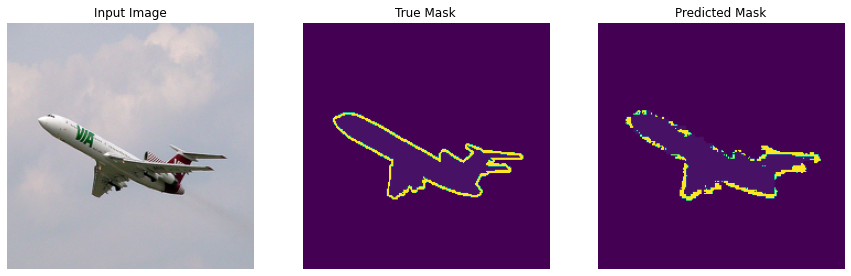


Classes detected:
0 background
6 bus
7 car
19 train
21 Unknown


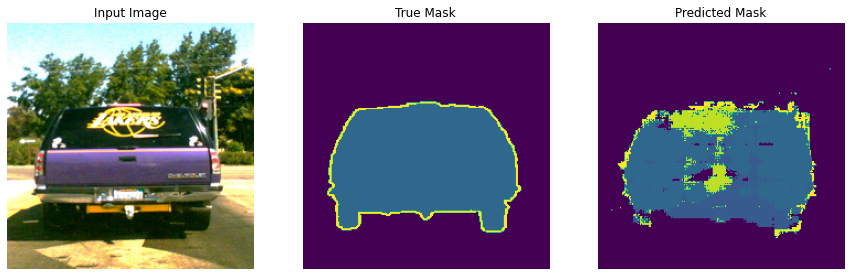


Classes detected:
0 background
1 aeroplane
21 Unknown


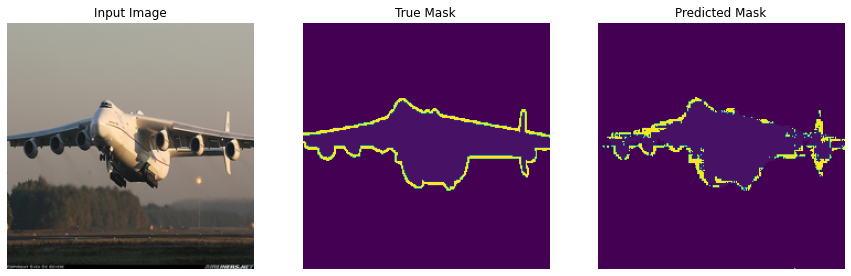


Classes detected:
0 background
4 boat
5 bottle
6 bus
7 car
20 tv/monitor
21 Unknown


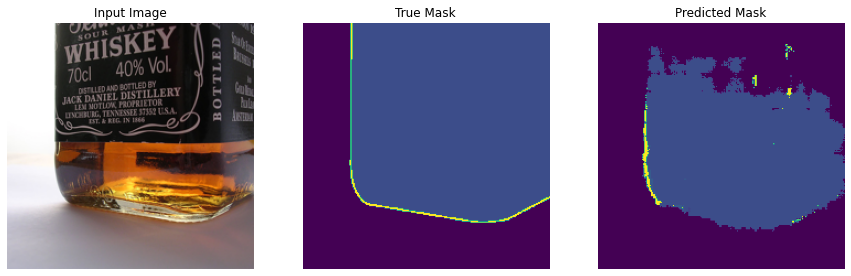


Classes detected:
0 background
3 bird
13 horse
15 person
19 train
21 Unknown


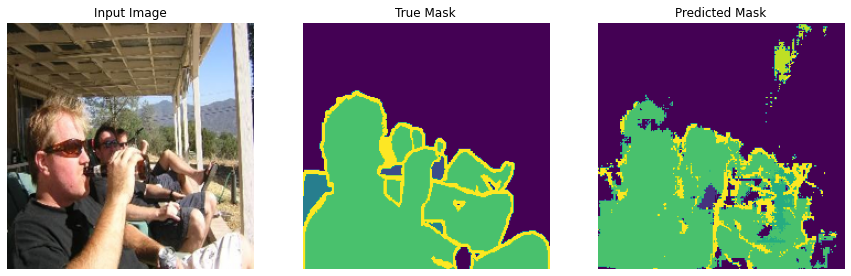

In [26]:
show_predictions(val_batches.shuffle(buffer_size=64), num =5)

## Extract Images from original image using predicted mask from Test dataset


Classes detected:
0 background
3 bird
13 horse
17 sheep
21 Unknown


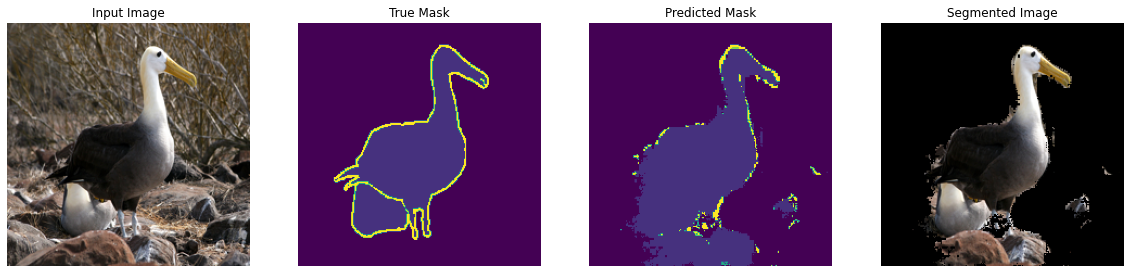


Classes detected:
0 background
3 bird
8 cat
10 cow
12 dog
13 horse
15 person
17 sheep
21 Unknown


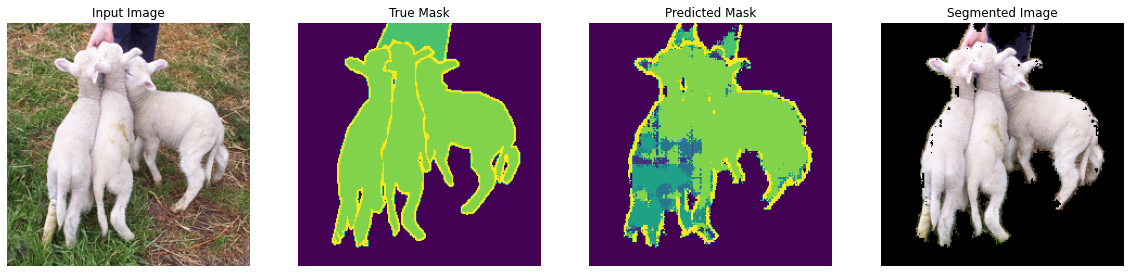


Classes detected:
0 background
1 aeroplane
21 Unknown


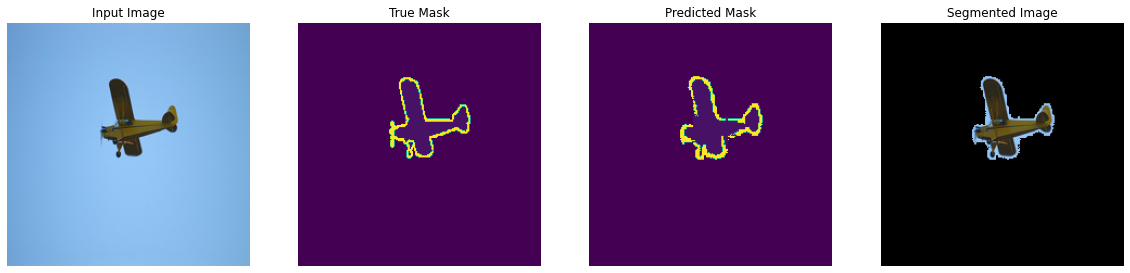


Classes detected:
0 background
1 aeroplane
21 Unknown


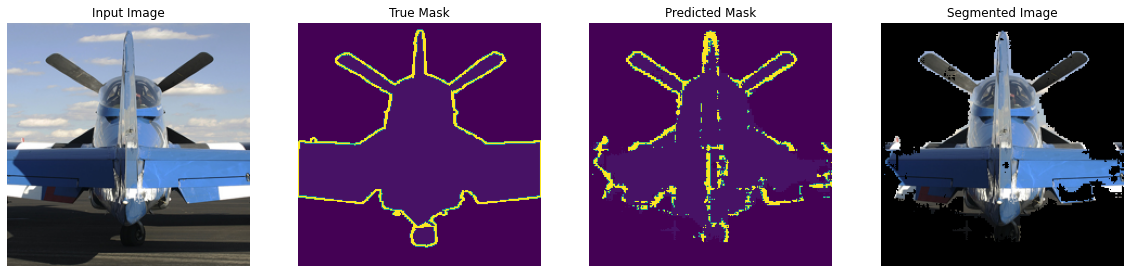


Classes detected:
0 background
1 aeroplane
4 boat
5 bottle
7 car
14 motorbike
15 person
21 Unknown


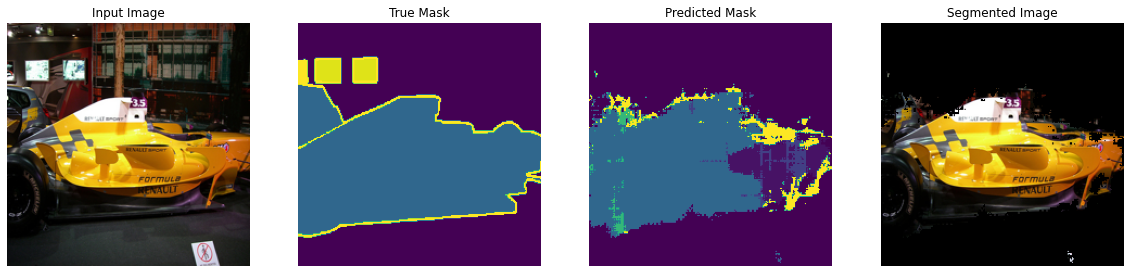


Classes detected:
0 background
20 tv/monitor
21 Unknown


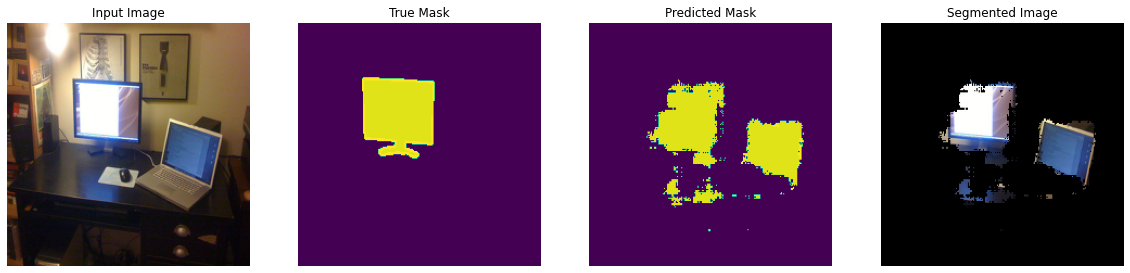


Classes detected:
0 background
3 bird
5 bottle
8 cat
12 dog
13 horse
15 person
21 Unknown


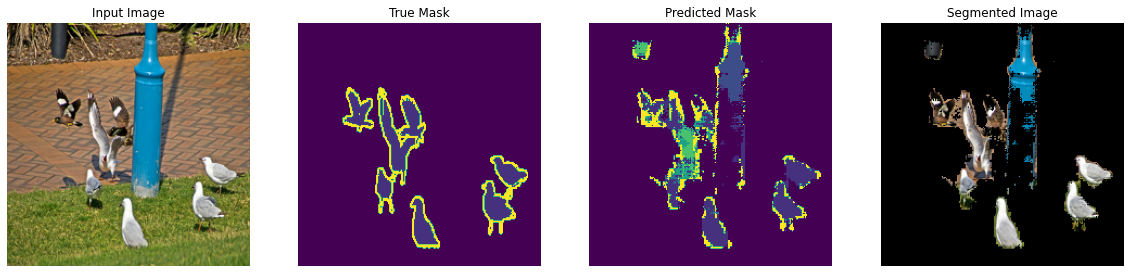


Classes detected:
0 background
3 bird
16 potted plant
21 Unknown


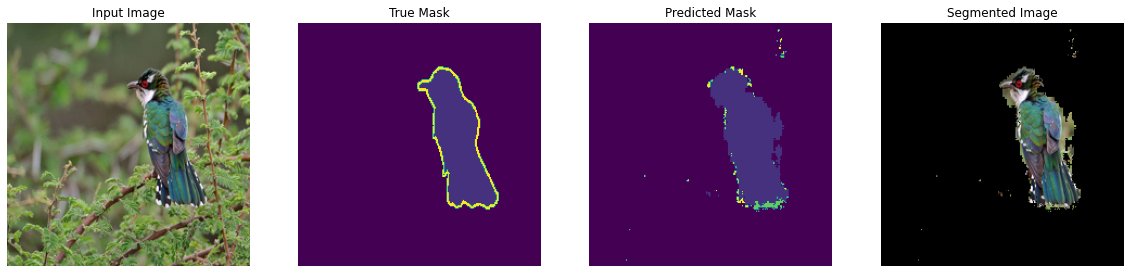


Classes detected:
0 background
2 bicycle
11 diningtable
14 motorbike
16 potted plant
21 Unknown


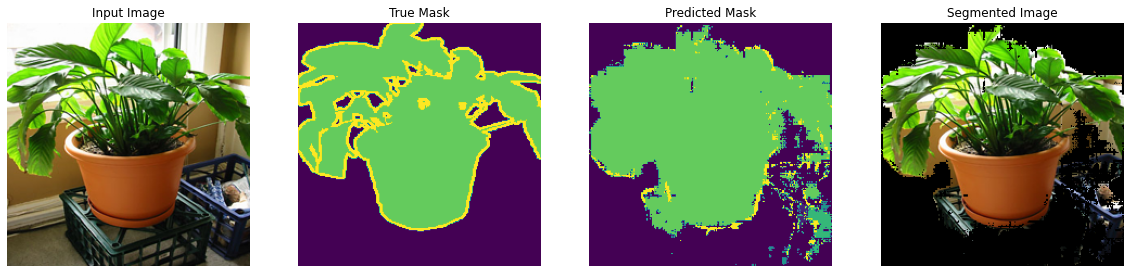


Classes detected:
0 background
3 bird
8 cat
10 cow
12 dog
13 horse
15 person
17 sheep
18 sofa
21 Unknown


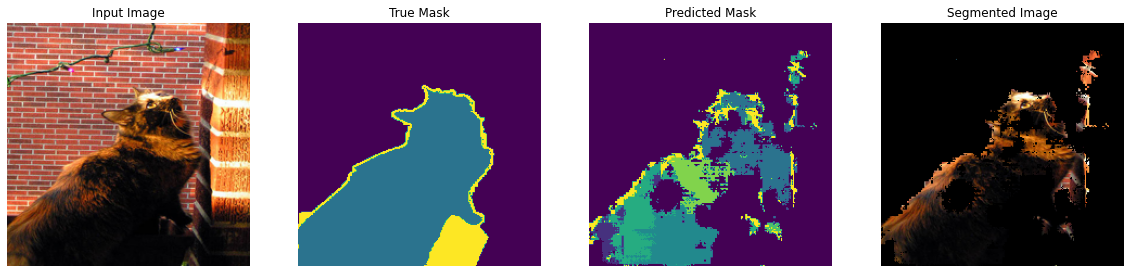

In [27]:
def display_results(display_list):
  plt.figure(figsize=(20, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask', 'Segmented Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

cnt = 0
for image, mask in test_batches.take(10):
    pred_mask_1 = model.predict(image)
    pred_mask_1 = create_mask(pred_mask_1)
    print_classes(np.unique(pred_mask_1))
    pred_mask = (np.array(pred_mask_1) !=0).astype(int)
    display_results([image[0], mask[0], pred_mask_1[:, :, 0], image[0] * pred_mask])
    cnt += 1